## Fine-Tuning the ViT Model (on the NIH and CheXpert Datasets)

### Part 1: Importing Libraries, Setting Directories, and Writing a Configuration Dictionary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import pandas as pd
from PIL import Image
import torch.nn as nn

In [2]:
# Setting Google Drive location
from google.colab import drive
drive.mount('/content/drive')
project_directory_drive = "/content/drive/MyDrive/"

# Setting random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

# Choosing device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("Saving to:", project_directory_drive)


Mounted at /content/drive
Device: cuda
Saving to: /content/drive/MyDrive/


In [16]:
# -----------------------------------------------------------------------------------
# CENTRAL CONFIG DICTIONARY (so I can see and edit all hyperparameters in one place)
# -----------------------------------------------------------------------------------
config = {

    "dataset": "nih",

    # ---------------- Training hyperparameters ----------------
    "num_epochs": 15,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "weight_decay": 1e-4,

    # ---------------- Scheduler hyperparameters ----------------
    "scheduler_Tmax": 10,

    # ---------------- Model architecture settings ----------------
    "num_classes": 2,
    "vit_name": "VIT_S16",
    "hidden_dim": 384,
    "img_size": 224,

    # ---------------- Pretrained ViT MoCo checkpoint ----------------
    "pretrained_vit_checkpoint": "/content/drive/MyDrive/ViT_MoCo_Project/artifacts/vit_baseline/checkpoint_epoch_4.pth",

    # CHEXPERT BINARY DATA
    # ======================================================================

    # ---------------- ZIP paths for extraction (CheXpert) ----------------
    "chexpert_zip_train": "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/binary_train.zip",
    "chexpert_zip_val":   "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/binary_val.zip",
    "chexpert_zip_test":  "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/binary_test.zip",

    # ---------------- Extraction directories (CheXpert) ----------------
    "chexpert_extract_train": "/tmp/CheXpert_binary_train/",
    "chexpert_extract_val":   "/tmp/CheXpert_binary_val/",
    "chexpert_extract_test":  "/tmp/CheXpert_binary_test/",

    # ---------------- CSVs for image labels (CheXpert) ----------------
    "chexpert_csv_train": "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/0_final_project_updated_names_train_transfer_binary.csv",
    "chexpert_csv_val":   "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/0_final_project_updated_names_val_transfer_binary.csv",
    "chexpert_csv_test":  "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/0_final_project_updated_names_test_transfer_binary.csv",

    # ======================================================================

    # NIH DATA
    # ======================================================================

    # ---------------- ZIP paths for extraction (NIH) ----------------
    "nih_zip_train": "/content/drive/MyDrive/Project_Eval/Datasets/NIH/train.zip",
    "nih_zip_val":   "/content/drive/MyDrive/Project_Eval/Datasets/NIH/val.zip",
    "nih_zip_test":  "/content/drive/MyDrive/Project_Eval/Datasets/NIH/test.zip",

    # ---------------- Extraction directories (NIH) ----------------
    "nih_extract_train": "/tmp/NIH_train/",
    "nih_extract_val":   "/tmp/NIH_val/",
    "nih_extract_test":  "/tmp/NIH_test/",

    # ---------------- CSV paths (NIH) ----------------
    "nih_csv_train": "/content/drive/MyDrive/Project_Eval/Datasets/NIH/nih_train.csv",
    "nih_csv_val":   "/content/drive/MyDrive/Project_Eval/Datasets/NIH/nih_val.csv",
    "nih_csv_test":  "/content/drive/MyDrive/Project_Eval/Datasets/NIH/nih_test.csv",

    # ======================================================================

    # ---------------- CHECKPOINT SAVING ----------------
    "save_every_epoch": True,
    "save_best_model": True,
    "output_checkpoint_dir": "/content/drive/MyDrive/Project_Eval/Models/"
}


In [19]:
# ------------------------------- !!!!!!!!!!!!
# UNZIPPING CHEXPERT BINARY TRAIN DATA (I am unzipping the training images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["chexpert_zip_train"]
extract_dir = config["chexpert_extract_train"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping CheXpert Binary Train"):
        z.extract(f, extract_dir)

CHEXPERT_BINARY_TRAIN_IMAGES = os.path.join(config["chexpert_extract_train"], "train")
CHEXPERT_BINARY_TRAIN_CSV = config["chexpert_csv_train"]

# ------------------------------- !!!!!!!!!!!!
# UNZIPPING CHEXPERT BINARY VAL DATA (I am unzipping the validation images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["chexpert_zip_val"]
extract_dir = config["chexpert_extract_val"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping CheXpert Binary Val"):
        z.extract(f, extract_dir)

CHEXPERT_BINARY_VAL_IMAGES   = os.path.join(config["chexpert_extract_val"], "val")
CHEXPERT_BINARY_VAL_CSV = config["chexpert_csv_val"]


# ------------------------------- !!!!!!!!!!!!
# UNZIPPING CHEXPERT BINARY TEST DATA (I am unzipping the test images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["chexpert_zip_test"]
extract_dir = config["chexpert_extract_test"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping CheXpert Binary Test"):
        z.extract(f, extract_dir)

CHEXPERT_BINARY_VAL_IMAGES   = os.path.join(config["chexpert_extract_test"], "test")
CHEXPERT_BINARY_VAL_CSV = config["chexpert_csv_test"]

# ===================================================================
# ------------------------- NIH DATA --------------------------------
# ===================================================================

# ------------------------------- !!!!!!!!!!!!
# UNZIPPING NIH TRAIN DATA (I am unzipping the NIH training images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["nih_zip_train"]
extract_dir = config["nih_extract_train"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping NIH Train"):
        z.extract(f, extract_dir)

NIH_TRAIN_IMAGES = os.path.join(extract_dir, "train/")
NIH_TRAIN_CSV = config["nih_csv_train"]


# ------------------------------- !!!!!!!!!!!!
# UNZIPPING NIH VAL DATA (I am unzipping the NIH validation images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["nih_zip_val"]
extract_dir = config["nih_extract_val"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping NIH Val"):
        z.extract(f, extract_dir)

NIH_VAL_IMAGES = os.path.join(extract_dir, "val/")
NIH_VAL_CSV = config["nih_csv_val"]

# ------------------------------- !!!!!!!!!!!!
# UNZIPPING NIH TEST DATA (I am unzipping the NIH test images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["nih_zip_test"]
extract_dir = config["nih_extract_test"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping NIH Test"):
        z.extract(f, extract_dir)

NIH_VAL_IMAGES = os.path.join(extract_dir, "test/")
NIH_VAL_CSV = config["nih_csv_test"]

Unzipping NIH Test: 100%|██████████| 583/583 [00:01<00:00, 487.13it/s]


In [5]:
class NIH_Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_root, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_root = img_root
        self.transform = transform

        # Label column
        if "Pneumonia" in self.df.columns:
            self.label_col = "Pneumonia"
        else:
            raise ValueError("CSV must contain 'Pneumonia' column.")

        # Path column
        if "Path" in self.df.columns:
            self.path_col = "Path"
        elif "path" in self.df.columns:
            self.path_col = "path"
        else:
            raise ValueError("CSV must contain 'Path' or 'path' column.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_rel_path = row[self.path_col]
        img_path = os.path.join(self.img_root, img_rel_path)

        if not os.path.exists(img_path):
            raise FileNotFoundError(
                f"Missing image:\n"
                f"  CSV: {img_rel_path}\n"
                f"  Tried: {img_path}"
            )

        image = Image.open(img_path).convert("RGB")
        label = int(row[self.label_col])

        if self.transform:
            image = self.transform(image)

        return image, label


### Part 2: Defining Patch Scoring Head

In [6]:
class PatchScoringHead(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, patches):
        return self.mlp(patches).squeeze(-1)

In [7]:
class PatchScoringViT(nn.Module):
    def __init__(self, backbone, num_classes=2, hidden_dim=128):
        super().__init__()

        self.backbone = backbone
        embed_dim = backbone.num_features

        self.scorer = PatchScoringHead(embed_dim, hidden_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, images):
        tokens = self.backbone.forward_features(images)
        patch_embeddings = tokens[:, 1:]                  # [B,196,D]

        patch_scores = self.scorer(patch_embeddings)      # [B,196]
        weights = torch.softmax(patch_scores, dim=1)

        pooled = (weights.unsqueeze(-1) * patch_embeddings).sum(dim=1)

        logits = self.classifier(pooled)
        return logits, patch_scores

### Part 3: Defining Dataloaders

In [8]:
def build_dataloaders():
    # I am resizing images to match the ViT input resolution.
    transform = transforms.Compose([
        transforms.Resize((config["img_size"], config["img_size"])),
        transforms.ToTensor()
    ])

    # Switching between CheXpert and NIH depending on config selection
    if config["dataset"].lower() == "chexpert":
        # Using ImageFolder because CheXpert binary ZIPs already contain train/ and val/ subfolders
        train_dataset = NIH_Dataset(CHEXPERT_BINARY_TRAIN_CSV, CHEXPERT_BINARY_TRAIN_IMAGES, transform)
        val_dataset   = NIH_Dataset(CHEXPERT_BINARY_VAL_CSV,   CHEXPERT_BINARY_VAL_IMAGES,   transform)

    elif config["dataset"].lower() == "nih":
        # Using NIH CSV-based dataset loader
        train_dataset = NIH_Dataset(NIH_TRAIN_CSV, NIH_TRAIN_IMAGES, transform)
        val_dataset   = NIH_Dataset(NIH_VAL_CSV,   NIH_VAL_IMAGES,   transform)

    else:
        raise ValueError("Unknown dataset. Choose 'chexpert' or 'nih' in config['dataset'].")

    # Creating dataloaders for training and validation datasets
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=config["batch_size"], shuffle=False)

    return train_loader, val_loader

In [9]:
import timm
import torch
import torch.nn as nn

def extract_encoder_q(model_state):
    encoder_q_state = {}
    for k, v in model_state.items():
        if k.startswith("encoder_q."):
            new_key = k.replace("encoder_q.", "")
            encoder_q_state[new_key] = v
    return encoder_q_state

def load_vit_s16_backbone(checkpoint_path, device):
    ckpt = torch.load(checkpoint_path, map_location=device)
    state = ckpt["model_state"]

    enc_q = extract_encoder_q(state)

    vit = timm.create_model(
        "vit_small_patch16_224",
        pretrained=False,
        num_classes=0
    ).to(device)

    missing, unexpected = vit.load_state_dict(enc_q, strict=False)
    print("Loaded ViT-S/16. Missing:", missing, "| Unexpected:", unexpected)

    feat_dim = vit.num_features
    return vit, feat_dim


In [10]:
import sys
sys.path.append("/content/drive/MyDrive/ViT_MoCo_Project/src")

## Part 4: Writing Validation and Training Functions

In [11]:
def evaluate_epoch_on_validation_set(model, dataloader, loss_function):
    # Putting the model in eval mode and instantiating prediction and loss counts.
    model.eval()
    running_loss_epoch = 0.0
    correct_predictions_epoch = 0
    total_predictions_epoch = 0

    # We do not need gradients for evaluation (so I am stopping gradient tracking to conserve memory).
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Running the forward pass through the model.
            outputs, _ = model(images)

            # Computing loss.
            loss = loss_function(outputs, labels)
            running_loss_epoch += loss.item() * labels.size(0)

            # Getting the predicted labels (using the class with maximum logit value).
            _, predicted_class_labels = torch.max(outputs, 1)

            # Counting correct predictions.
            min_length = min(predicted_class_labels.size(0), labels.size(0))
            for i in range(min_length):
                total_predictions_epoch += 1
                if predicted_class_labels[i].item() == labels[i].item():
                    correct_predictions_epoch += 1

    # Computing average loss and classification accuracy.
    average_loss_epoch = running_loss_epoch / (total_predictions_epoch + 1e-8)
    percent_correct_epoch = (correct_predictions_epoch / total_predictions_epoch) * 100

    return average_loss_epoch, percent_correct_epoch


In [12]:
def train_patchscoring_vit():
    # Build loaders
    train_loader, val_loader = build_dataloaders()

    # ---------------------------------------------
    # LOAD MOCO BACKBONE FIRST
    # ---------------------------------------------
    backbone, feat_dim = load_vit_s16_backbone(config["pretrained_vit_checkpoint"], device)

    vit_model = PatchScoringViT(
        backbone=backbone,
        num_classes=config["num_classes"],
        hidden_dim=config["hidden_dim"]
    ).to(device)

    # DEFINING OPTIMIZER, SCHEDULER, AND LOSS FUNCTION
    epochs=config["num_epochs"]
    learning_rate=config["learning_rate"]
    weight_decay=config["weight_decay"]

    optimizer = optim.AdamW(vit_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_function = nn.CrossEntropyLoss()

    # Creating lists for logging training/validation metrics.
    training_losses = []
    validation_losses = []
    validation_accuracies = []

    best_validation_loss = float("inf")
    best_model_file = os.path.join(project_directory_drive, "tuning_nih.pth")

    print("Starting training...\n")

    for epoch in tqdm(range(0, epochs), desc="Training", unit="epoch"):
        # Putting model in training mode and instantiating prediction and loss counts.
        vit_model.train()
        running_loss = 0.0
        total_predictions = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Resetting the parameter gradients (so the prior epoch gradients are not comingled with the current ones).
            optimizer.zero_grad()

            # Performing the forward pass (with mixed precision).
            outputs, _ = vit_model(images)
            loss = loss_function(outputs, labels)

            # Performing the backward and optimization steps.
            loss.backward()
            optimizer.step()

            # Accumulating the running loss and total predictions (for printing).
            running_loss += loss.item() * labels.size(0)
            total_predictions += labels.size(0)

        # Computing average training loss for this epoch.
        training_loss = running_loss / total_predictions

        # Evaluating on the validation set after this training epoch.
        validation_loss, validation_accuracy = evaluate_epoch_on_validation_set(
            vit_model, val_loader, loss_function
        )

        # Logging metrics.
        training_losses.append(training_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Saving best model checkpoint.
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            torch.save(vit_model.state_dict(), best_model_file)

        # Printing training and validation results (matching your exact format).
        print(
            f"[Epoch {epoch + 1}/{epochs}] "
            f"Train Loss: {training_loss:.4f}, "
            f"Val Loss: {validation_loss:.4f}, "
            f"Val Acc: {validation_accuracy:.2f}%"
        )

        # Stepping the learning rate scheduler.
        scheduler.step()

    print("Training completed. Best model saved to:", best_model_file)

    return vit_model, training_losses, validation_losses, validation_accuracies

In [17]:
trained_model, training_losses, validation_losses, validation_accuracies = train_patchscoring_vit()

Loaded ViT-S/16. Missing: [] | Unexpected: []
Starting training...



Training:   7%|▋         | 1/15 [01:35<22:17, 95.54s/epoch]

[Epoch 1/15] Train Loss: 0.5125, Val Loss: 1.2108, Val Acc: 53.33%


Training:  13%|█▎        | 2/15 [03:10<20:41, 95.47s/epoch]

[Epoch 2/15] Train Loss: 0.3992, Val Loss: 1.6192, Val Acc: 48.33%


Training:  20%|██        | 3/15 [04:46<19:04, 95.41s/epoch]

[Epoch 3/15] Train Loss: 0.3652, Val Loss: 1.5703, Val Acc: 50.00%


Training:  27%|██▋       | 4/15 [06:21<17:30, 95.51s/epoch]

[Epoch 4/15] Train Loss: 0.3320, Val Loss: 1.0734, Val Acc: 53.33%


Training:  33%|███▎      | 5/15 [07:57<15:54, 95.50s/epoch]

[Epoch 5/15] Train Loss: 0.3286, Val Loss: 1.5168, Val Acc: 51.67%


Training:  40%|████      | 6/15 [09:32<14:19, 95.47s/epoch]

[Epoch 6/15] Train Loss: 0.3208, Val Loss: 1.0752, Val Acc: 53.33%


Training:  47%|████▋     | 7/15 [11:08<12:43, 95.49s/epoch]

[Epoch 7/15] Train Loss: 0.3051, Val Loss: 0.8978, Val Acc: 60.00%


Training:  53%|█████▎    | 8/15 [12:43<11:07, 95.42s/epoch]

[Epoch 8/15] Train Loss: 0.2890, Val Loss: 1.0314, Val Acc: 53.33%


Training:  60%|██████    | 9/15 [14:19<09:32, 95.41s/epoch]

[Epoch 9/15] Train Loss: 0.2729, Val Loss: 0.9760, Val Acc: 60.00%


Training:  67%|██████▋   | 10/15 [15:54<07:57, 95.41s/epoch]

[Epoch 10/15] Train Loss: 0.2580, Val Loss: 1.1052, Val Acc: 58.33%


Training:  73%|███████▎  | 11/15 [17:29<06:21, 95.40s/epoch]

[Epoch 11/15] Train Loss: 0.2332, Val Loss: 1.0695, Val Acc: 60.00%


Training:  80%|████████  | 12/15 [19:05<04:46, 95.41s/epoch]

[Epoch 12/15] Train Loss: 0.2129, Val Loss: 1.1680, Val Acc: 61.67%


Training:  87%|████████▋ | 13/15 [20:40<03:10, 95.41s/epoch]

[Epoch 13/15] Train Loss: 0.1898, Val Loss: 1.1955, Val Acc: 61.67%


Training:  93%|█████████▎| 14/15 [22:15<01:35, 95.38s/epoch]

[Epoch 14/15] Train Loss: 0.1705, Val Loss: 1.3582, Val Acc: 58.33%


Training: 100%|██████████| 15/15 [23:51<00:00, 95.42s/epoch]

[Epoch 15/15] Train Loss: 0.1600, Val Loss: 1.2968, Val Acc: 61.67%
Training completed. Best model saved to: /content/drive/MyDrive/tuning_nih.pth


In [20]:
# ============================================================
#                FINAL EVALUATION USING trained_model
# ============================================================

print("\n================ EVALUATION START ================\n")

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
    confusion_matrix,
    auc,
    accuracy_score
)

# ----------------------------
# 1. Rebuild Test Loader
# ----------------------------
def build_test_loader():
    transform = transforms.Compose([
        transforms.Resize((config["img_size"], config["img_size"])),
        transforms.ToTensor(),
    ])

    # Choose dataset based on config
    test_csv = config["chexpert_csv_test"] if config["dataset"] == "chexpert" else config["nih_csv_test"]
    test_root = config["chexpert_extract_test"] if config["dataset"] == "chexpert" else config["nih_extract_test"]

    test_dataset = NIH_Dataset(test_csv, test_root + "test/", transform)
    return DataLoader(test_dataset, batch_size=32, shuffle=False)

test_loader = build_test_loader()


# ----------------------------
# 2. Model = trained_model
# ----------------------------
eval_model = trained_model
eval_model.eval()
print("✓ Using trained_model for evaluation\n")


# ----------------------------
# 3. Collect Predictions
# ----------------------------
def collect_predictions(model, loader):
    y_true = []
    y_prob = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)

            logits, _ = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]  # probability positive class

            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    return np.array(y_true), np.array(y_prob)


# ----------------------------
# 4. Run on Test Set
# ----------------------------
y_true, y_prob = collect_predictions(eval_model, test_loader)
y_pred = (y_prob >= 0.5).astype(int)


# ----------------------------
# 5. Compute Metrics
# ----------------------------
acc = accuracy_score(y_true, y_pred) * 100
roc_auc = roc_auc_score(y_true, y_prob)

precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall_curve, precision_curve)

# per-class metrics
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1], zero_division=0
)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()


# ----------------------------
# 6. Print Summary (Matches Your Paper Format)
# ----------------------------
print("============== TEST SET METRICS ==============")
print(f"Accuracy:      {acc:.2f}%")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"PR-AUC:        {pr_auc:.4f}\n")

print("Per-Class Metrics:")
print("Class | Precision | Recall | F1")
print("--------------------------------")
print(f"0     | {prec[0]:.2f}      | {rec[0]:.2f}   | {f1[0]:.2f}")
print(f"1     | {prec[1]:.2f}      | {rec[1]:.2f}   | {f1[1]:.2f}\n")

print("Confusion Matrix:")
print(f"TP: {tp}   FP: {fp}")
print(f"FN: {fn}   TN: {tn}")
print("==============================")


================ EVALUATION START ================

✓ Using trained_model for evaluation

============== TEST SET METRICS ==============
Accuracy:      77.24%
ROC-AUC:       0.9119
PR-AUC:        0.9472

Per-Class Metrics:
Class | Precision | Recall | F1
--------------------------------
0     | 0.93      | 0.41   | 0.57
1     | 0.74      | 0.98   | 0.85

Confusion Matrix:
TP: 361   FP: 125
FN: 7   TN: 87


In [25]:
def plot_confusion_matrix_matched(cm, save_path, title_dataset="Pneumonia Classification", model_name="ViT-S"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: Finetune {model_name} {title_dataset}')

    plt.savefig(save_path)
    plt.close()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix_matched(
    cm,
    save_path = "/content/drive/MyDrive/ViT_MoCo_Project/confusion_matrix_vits_nih.png",
    model_name="ViT-S",
    title_dataset="Pneumonia Classification"
)

## Part 6: Patch-Level Visualization

In [58]:
# === GET ONE POSITIVE-PNEUMONIA SAMPLE ===

pos_img = None
pos_label = None

for imgs, lbls in val_loader:
    for i in range(len(lbls)):
        if lbls[i].item() == 1:      # pneumonia positive
            pos_img = imgs[i].to(device)
            pos_label = lbls[i].item()
            break
    if pos_img is not None:
        break

if pos_img is None:
    raise ValueError("❌ No positive pneumonia samples found in validation set.")
else:
    print("Found positive sample! Label =", pos_label)

# 4. Run model forward pass to get logits + patch_scores
trained_model.eval()
with torch.no_grad():
    logits, patch_scores = trained_model(pos_img.unsqueeze(0))

# 5. IMPORTANT: remove batch dimension and move to CPU
patch_scores = patch_scores[0]    # shape: (196,)
pos_img_vis = pos_img.cpu()               # already in [0,1] because you did NOT normalize
print()

Found positive sample! Label = 1



In [53]:
# === VISUALIZE PATCH SCORES ON ONE VALIDATION SAMPLE ===

# 1. Rebuild validation loader exactly like in training
_, val_loader = build_dataloaders()

# 2. Get one batch
images, labels = next(iter(val_loader))

# 3. Pick first image
img = images[14].to(device)

print(labels[1].to(device))

# 4. Run model forward pass to get logits + patch_scores
trained_model.eval()
with torch.no_grad():
    logits, patch_scores = trained_model(img.unsqueeze(0))

# 5. IMPORTANT: remove batch dimension and move to CPU
patch_scores = patch_scores[0]    # shape: (196,)
img_vis = img.cpu()               # already in [0,1] because you did NOT normalize

tensor(0, device='cuda:0')


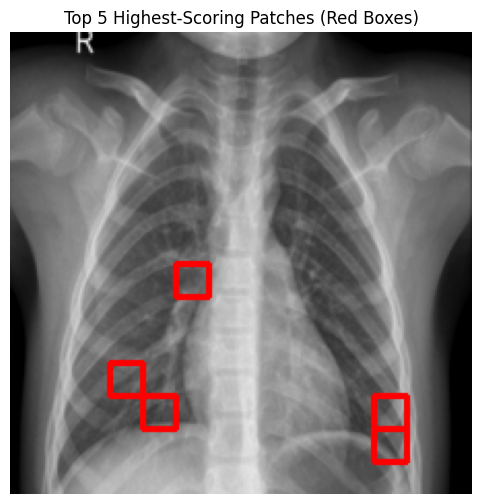

In [38]:
def visualize_patch_importance(model, dataloader, device, k=10):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import torch

    # 1) Get one sample from loader
    model.eval()
    images, labels = next(iter(dataloader))
    img = images[0].to(device)              # (3,224,224)

    with torch.no_grad():
        logits, patch_scores = model(img.unsqueeze(0))

    patch_scores = patch_scores[0]          # (196,)

    # 2) Prep score data
    scores = patch_scores.detach().cpu().numpy()
    topk_idx = np.argsort(scores)[-k:]      # top-K patch indices

    # Convert indices → patch grid coords
    coords = [(i // 14, i % 14) for i in topk_idx]

    # 3) Convert image for drawing
    img_np = img.cpu().permute(1,2,0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_draw = img_np.copy()

    patch_size = 16   # for ViT-B/16

    # 4) Draw red bounding boxes
    for (r, c) in coords:
        y1, x1 = r * patch_size, c * patch_size
        y2, x2 = y1 + patch_size, x1 + patch_size
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255,0,0), 2)

    # 5) Display result
    plt.figure(figsize=(6,6))
    plt.imshow(img_draw)
    plt.axis("off")
    plt.title(f"Top {k} Highest-Scoring Patches (Red Boxes)")
    plt.show()

    return img_draw, scores

_ = visualize_patch_importance(trained_model, val_loader, device, k=5)

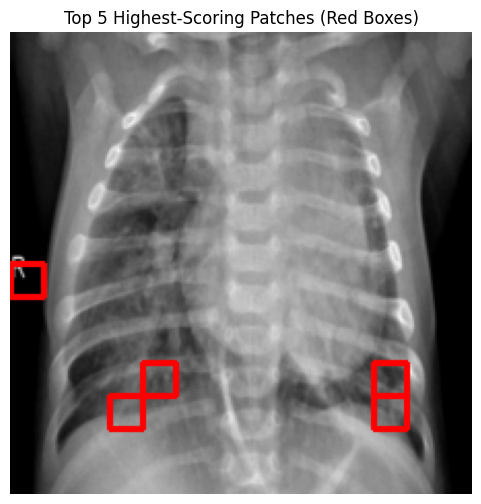

In [73]:
def visualize_patch_importance(model, device, dataloader=None, img_tensor=None, k=10):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import torch

    model.eval()

    # -------------------------------------------------------
    # 1) Choose input image
    # -------------------------------------------------------
    if img_tensor is not None:
        img = img_tensor.to(device)   # (3,224,224)
    else:
        if dataloader is None:
            raise ValueError("Must provide either img_tensor or dataloader.")
        images, labels = next(iter(dataloader))
        img = images[0].to(device)

    # -------------------------------------------------------
    # 2) Forward pass
    # -------------------------------------------------------
    with torch.no_grad():
        logits, patch_scores = model(img.unsqueeze(0))

    patch_scores = patch_scores[0]   # (196,)

    # -------------------------------------------------------
    # 3) Prepare data
    # -------------------------------------------------------
    scores = patch_scores.detach().cpu().numpy()
    topk_idx = np.argsort(scores)[-k:]   # top-K patches
    coords = [(i // 14, i % 14) for i in topk_idx]

    # -------------------------------------------------------
    # 4) Prepare image for drawing
    # -------------------------------------------------------
    img_np = img.cpu().permute(1,2,0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_draw = img_np.copy()

    patch_size = 16

    # -------------------------------------------------------
    # 5) Draw bounding boxes
    # -------------------------------------------------------
    for (r, c) in coords:
        y1, x1 = r * patch_size, c * patch_size
        y2, x2 = y1 + patch_size, x1 + patch_size
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255,0,0), 2)

    # -------------------------------------------------------
    # 6) Display final result
    # -------------------------------------------------------
    plt.figure(figsize=(6,6))
    plt.imshow(img_draw)
    plt.axis("off")
    plt.title(f"Top {k} Highest-Scoring Patches (Red Boxes)")
    plt.show()

    return img_draw, scores

img_draw, scores = visualize_patch_importance(
    model=trained_model,
    device=device,
    img_tensor=pos_img,
    k=5
)


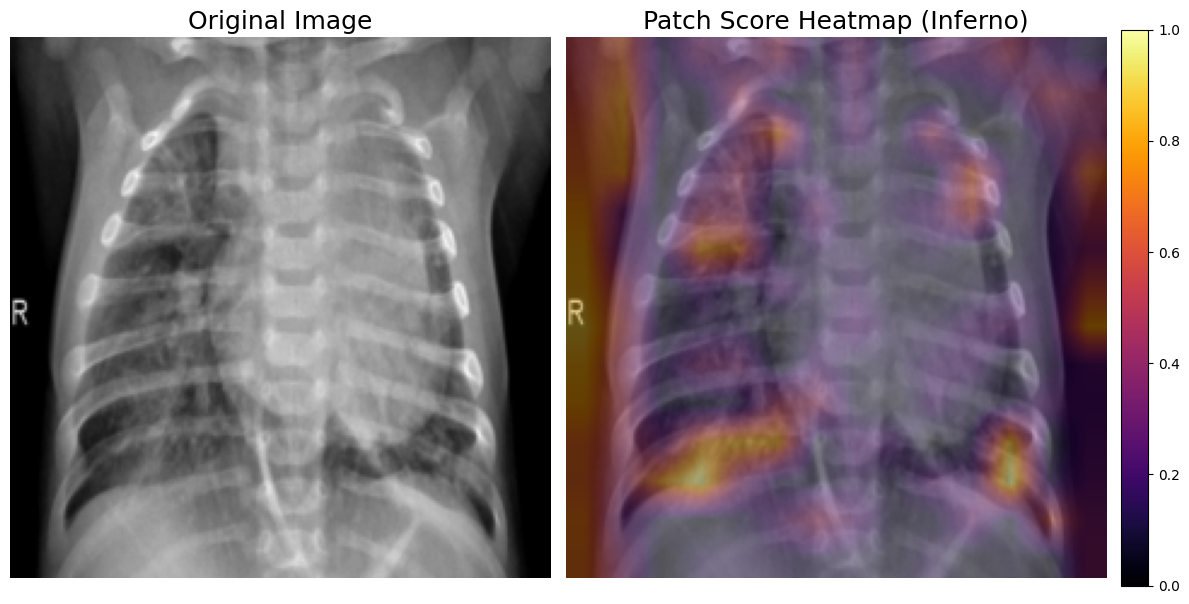

In [59]:
def visualize_patch_scores_clinical(image_tensor, scores):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import matplotlib.cm as cm
    from matplotlib import gridspec

    # --- Convert image to displayable uint8 ---
    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # --- Normalize patch scores but keep true min/max for colorbar ---
    s = scores.detach().cpu().numpy()
    s_min, s_max = s.min(), s.max()
    s_norm = (s - s_min) / (s_max - s_min + 1e-8)

    # --- 14x14 → 224x224 heatmap ---
    heat = s_norm.reshape(14, 14)
    heat = cv2.resize(heat, (224, 224), interpolation=cv2.INTER_LINEAR)

    # --- Colorize ---
    cmap = cm.inferno
    heat_color = (cmap(heat)[..., :3] * 255).astype(np.uint8)

    # --- Blend with original ---
    overlay = (0.6 * img + 0.4 * heat_color).astype(np.uint8)

    # --- Grid layout to prevent squeezing ---
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    cax = plt.subplot(gs[2])  # dedicated colorbar axis

    # Left: Original
    ax0.imshow(img)
    ax0.axis("off")
    ax0.set_title("Original Image", fontsize=18)

    # Right: Heatmap overlay
    im = ax1.imshow(overlay)
    ax1.axis("off")
    ax1.set_title("Patch Score Heatmap (Inferno)", fontsize=18)

    # Colorbar with true raw score scale
    norm = plt.Normalize(vmin=0.0, vmax=1.0)
    sm = cm.ScalarMappable(norm=norm, cmap="inferno")
    sm.set_array([])

    cb = plt.colorbar(sm, cax=cax)

    plt.tight_layout()
    plt.show()


visualize_patch_scores_clinical(pos_img, patch_scores)

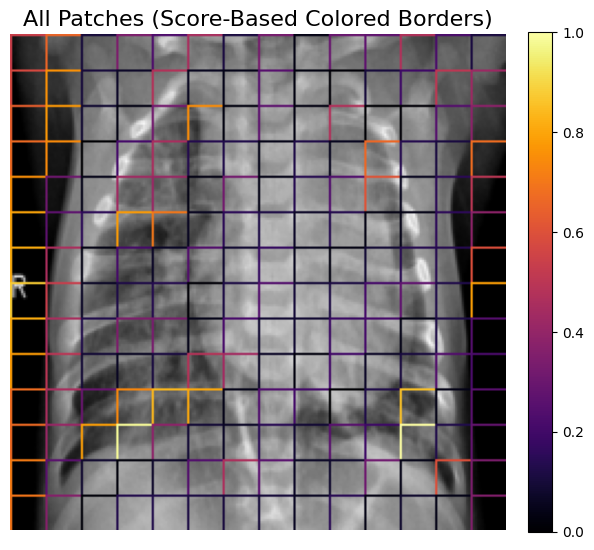

array([[[201,  63,  74],
        [201,  63,  74],
        [201,  63,  74],
        ...,
        [ 26,  11,  64],
        [ 26,  11,  64],
        [ 26,  11,  64]],

       [[201,  63,  74],
        [ 17,  17,  17],
        [ 19,  19,  19],
        ...,
        [ 91,  91,  91],
        [ 91,  91,  91],
        [ 87,  87,  87]],

       [[201,  63,  74],
        [ 15,  15,  15],
        [ 19,  19,  19],
        ...,
        [ 91,  91,  91],
        [ 86,  86,  86],
        [ 80,  80,  80]],

       ...,

       [[242, 117,  26],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[242, 117,  26],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[242, 117,  26],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
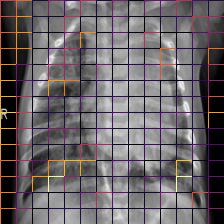

In [60]:
def visualize_all_patches(image_tensor, patch_scores):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import matplotlib.cm as cm

    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # Normalize patch scores
    s = patch_scores.detach().cpu().numpy()
    s_norm = (s - s.min()) / (s.max() - s.min() + 1e-8)
    grid = s_norm.reshape(14,14)

    cmap = cm.inferno
    patch_size = 16
    img_draw = img.copy()

    # DRAW BORDERS
    for r in range(14):
        for c in range(14):
            score = grid[r,c]

            rgb = np.array(cmap(score)[:3]) * 255
            rgb = rgb.astype(np.uint8)
            color = (int(rgb[0]), int(rgb[1]), int(rgb[2]))

            y1, x1 = r * patch_size, c * patch_size
            y2, x2 = y1 + patch_size, x1 + patch_size

            cv2.rectangle(img_draw, (x1, y1), (x2, y2), color, 1)

    # PLOT WITH COLORBAR
    fig, ax = plt.subplots(figsize=(7,7))

    im = ax.imshow(img_draw)
    ax.axis("off")
    ax.set_title("All Patches (Score-Based Colored Borders)", fontsize=16)

    # Create colorbar using normalized scale (0–1)
    norm = plt.Normalize(vmin=0.0, vmax=1.0)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # add colorbar matching height of the image
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)

    plt.show()

    return img_draw

visualize_all_patches(pos_img, patch_scores)